#### Import modules & prepare data

In [4]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import other modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from os import walk
from time import sleep
from IPython.display import clear_output
%matplotlib inline

# Data source: https://www.kaggle.com/stephenmugisha/particle-collisions

_, _, files = next(walk('data'))

target_names = {
    '0': 'electron',    # Negatively charged particle that is a lepton  (doesn't take part in strong force).
    '1': 'muon',    # Electron with 200 times more mass and makes up lots of cosmic radiation.
    '2': 'pion',    # Meson (connects with strong force) that can be positive, negative, or neutral
    '3': 'kaon',    # Pion with more mass.
    '4': 'proton'    # Positively charged particle with 2 up quarks and 1 down quark.
}

# Check how the data is formatted/stored.
file_test = open(f'data/{files[0]}', 'rb')
file = pickle.load(file_test)

print(file[0].shape)    # Group of 3000 images.
print(file[0][0].shape)    # Check first image.
print(file[1].shape)    # Group of 3000 targets.
print(file[1][0])    #    Classified as 'pion.'

# Collect all the data.
data = []
target = []

for file in files:
    file = open(f'data/{files[0]}', 'rb')
    file =  pickle.load(file)

    for sample, sample_target in zip(file[0], file[1]):
        data.append(sample)
        target.append(sample_target)

data = np.array(data)
target = np.array(target)

sleep(7)
clear_output()

print(data.shape)
print(target.shape)


(1259300, 10, 10)
(1259300,)


#### Data analysis

(944475, 10, 10, 1)
(944475, 5)
(314825, 10, 10, 1)
(314825, 5)


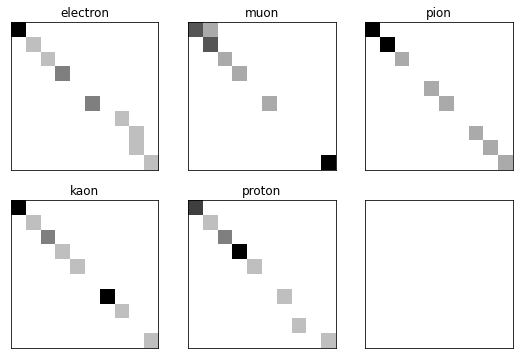

In [5]:
# Check for NaN values.
print(np.isnan(np.sum(data)))    # -> False

# Check range of values.
print(np.max(data), np.min(data))    # -> 8, 0

sleep(4)
clear_output()

# Edit target values to 0, 1, 2....
new_target = []

for tar in target:
    if tar == 11:
        new_target.append(0)
    elif tar == 13:
        new_target.append(1)
    elif tar == 211:
        new_target.append(2)
    elif tar == 321:
        new_target.append(3)
    else:
        new_target.append(4)
    
target = np.array(new_target)

# Get indexes for each different target possibility.
indexes = [
    np.where(target == 0)[0][0],
    np.where(target == 1)[0][0],
    np.where(target == 2)[0][0],
    np.where(target == 3)[0][0],
    np.where(target == 4)[0][0],
]

samples = [data[index] for index in indexes]
samples_target = [target_names[str(target[index])] for index in indexes]

fig, axs = plt.subplots(2, 3, figsize=(9, 6), subplot_kw={
    'yticks': (),
    'xticks': ()
})

axs = [ax for ax in axs.flatten()]

for sample, sample_target, ax in zip(samples, samples_target, axs):
    ax.imshow(sample, cmap='binary')
    ax.set_title(str(sample_target))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale and reshape data back to og form.
X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


#### Create Model

0.7790433764457703
0.7790455222129822


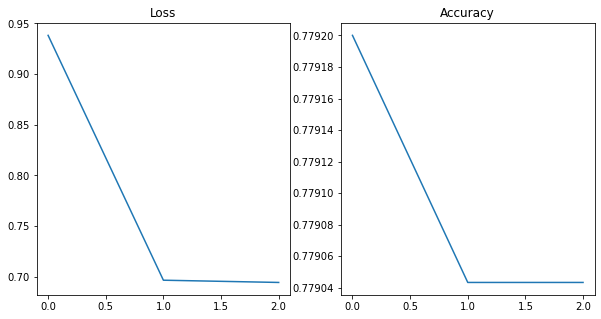

In [6]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(50, activation='relu', kernel_regularizer='l2'),
            Dense(50, activation='relu', kernel_regularizer='l2'),
            Dense(50, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(5, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

model = Model()

model.build(input_shape=(1, 10, 10, 1))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=64).history

sleep(4)
clear_output()

print(model.evaluate(X_train, y_train, verbose=False)[1])
print(model.evaluate(X_test, y_test, verbose=False)[1])

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))

ax_1.plot(range(3), history['loss'])
ax_2.plot(range(3), history['accuracy'])

ax_1.set_title('Loss')
ax_2.set_title('Accuracy');


#### Conclussion:
The algorithm shows that there is some pattern in predicting particle collisions, but still some inconsistency.

### More data analysis

In [ ]:
# TODO: look into trends of the data, specifically what it did wrong. Look at the methods like evaluate and try to figure out other properties/parameters.